In [47]:
import pandas as pd
import pandas as pd
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

In [2]:
dataset = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

# Read the dataset into a Pandas DataFrame
TITANIC = pd.read_csv(dataset)

In [2]:
import sys
sys.path.append('..')
from xDL.models.NATT import NATT

In [4]:
model = NATT(
    "survived ~  -1 + MLP(fare) +  MLP(age) + Transformer(sex):Transformer(deck)", 
    data=TITANIC, 
    feature_dropout=0.0001,
    binning_task="regression"
    )

In [5]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None, "att_weights": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR'), tf.keras.metrics.AUC(name="auc")], "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=20, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/20
1/1 [==============================] - 8s 8s/step - loss: 0.6683 - output_loss: 0.6683 - output_PR AUC: 0.4227 - output_auc: 0.5573 - val_loss: 0.5942 - val_output_loss: 0.5942 - val_output_PR AUC: 0.8230 - val_output_auc: 0.8428
Epoch 2/20
1/1 [==============================] - 0s 102ms/step - loss: 0.6266 - output_loss: 0.6266 - output_PR AUC: 0.5646 - output_auc: 0.6843 - val_loss: 0.5562 - val_output_loss: 0.5562 - val_output_PR AUC: 0.7499 - val_output_auc: 0.8237
Epoch 3/20
1/1 [==============================] - 0s 102ms/step - loss: 0.5609 - output_loss: 0.5609 - output_PR AUC: 0.7047 - output_auc: 0.7729 - val_loss: 0.4725 - val_output_loss: 0.4725 - val_output_PR AUC: 0.8301 - val_output_auc: 0.8523
Epoch 4/20
1/1 [==============================] - 0s 98ms/step - loss: 0.5282 - output_loss: 0.5282 - output_PR AUC: 0.7311 - output_auc: 0.8111 - val_loss: 0.5519 - val_output_loss: 0.5519 - val_output_PR AUC: 0.7624 - val_output_auc: 0.7718
Epoch 5/20
1/1 [============

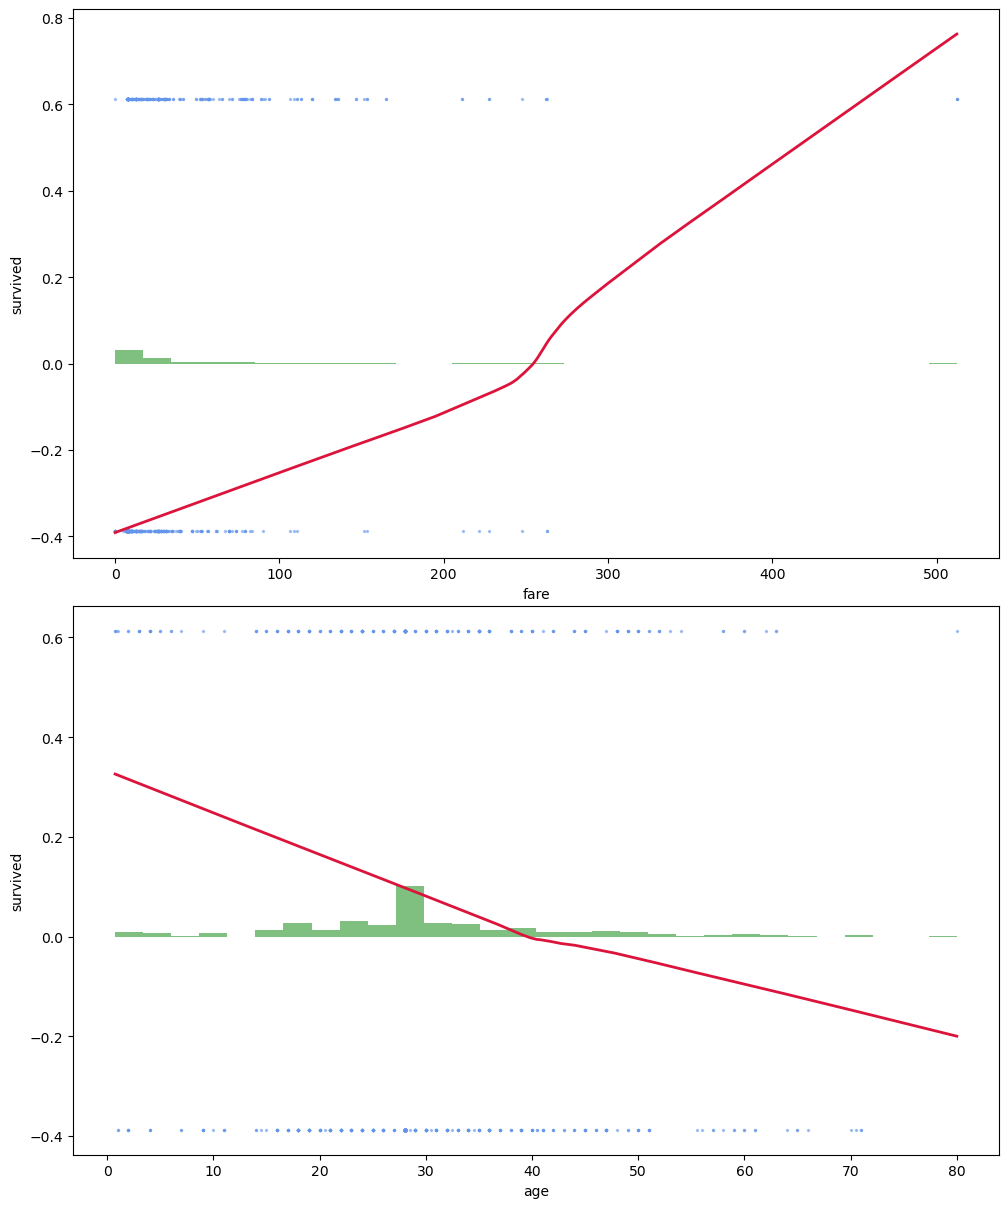

In [6]:
model.plot()

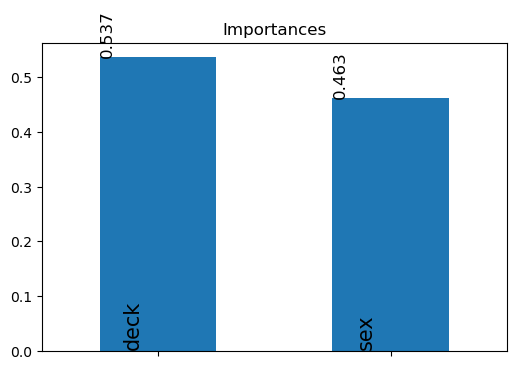

In [7]:
model.plot_importances()

In [13]:
model.encoder

In [28]:
dataset

<_TensorSliceDataset element_spec=({'sex': TensorSpec(shape=(1,), dtype=tf.int64, name=None), 'deck': TensorSpec(shape=(1,), dtype=tf.int64, name=None)}, TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [35]:
import numpy as np
dataset = model.plotting_data
dataset["deck"] = np.zeros(len(dataset), dtype=int)

In [38]:
from xDL.utils.data_utils import *

dataset = df_to_dataset(
            dataset,
            model.data,
            model.input_dict,
            model.y,
            batch_size=1024,
            shuffle=False,
            feature_information=model.feature_information,
            task=model.binning_task,
        )

1/1 [==============================] - 0s 62ms/step


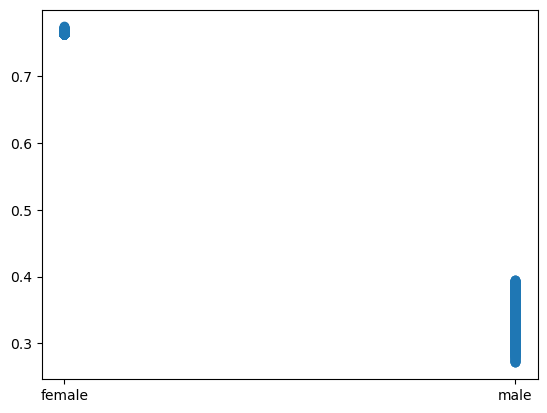

In [61]:
import matplotlib.pyplot as plt
preds = model.predict(dataset)
preds = preds["output"].squeeze()

plt.scatter(model.plotting_data["sex"], preds)

<Figure size 1200x400 with 0 Axes>

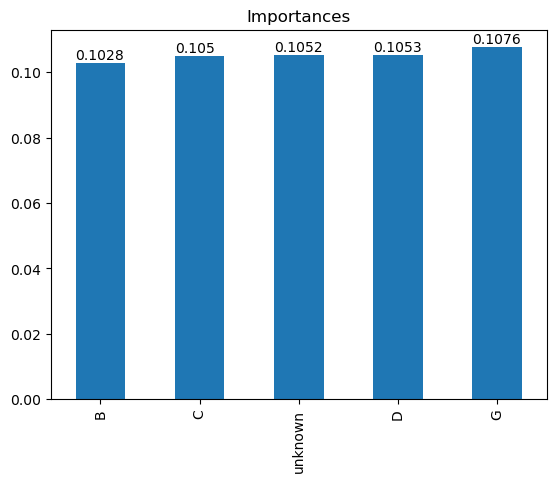

In [10]:
model.plot_categorical_importances()

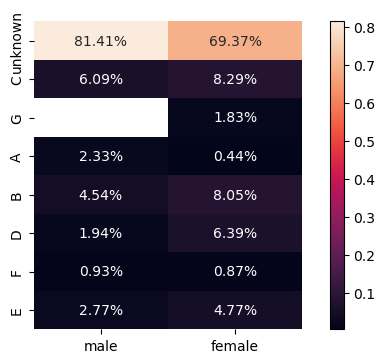

In [11]:
model.plot_heatmap_importances("sex", "deck")

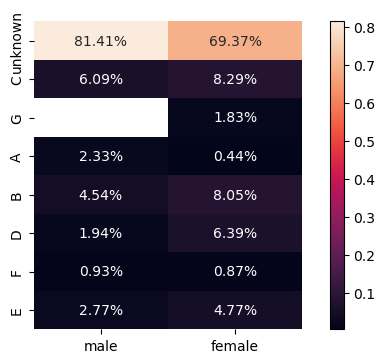

In [12]:
model.plot_heatmap_importances("sex", "deck")

# test continuous feature interactions

In [ ]:
model = NATT(
    "survived ~  -1 + MLP(fare):MLP(age) + Transformer(sex):Transformer(deck):Transformer(embark_town)",
    data=TITANIC, 
    feature_dropout=0.0001)

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.BinaryCrossentropy(), "importances": None, "att_weights": None},
    metrics= {"output": [tf.keras.metrics.AUC(name="PR AUC", curve='PR'), "accuracy"], "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=30, 
    validation_data=model.validation_dataset,
    verbose=1
)

Epoch 1/30
1/1 [==============================] - 17s 17s/step - loss: 0.8287 - output_loss: 0.8287 - output_PR AUC: 0.3849 - output_accuracy: 0.3865 - val_loss: 0.6251 - val_output_loss: 0.6251 - val_output_PR AUC: 0.6855 - val_output_accuracy: 0.6720
Epoch 2/30
1/1 [==============================] - 0s 249ms/step - loss: 0.6759 - output_loss: 0.6759 - output_PR AUC: 0.4666 - output_accuracy: 0.5797 - val_loss: 0.6190 - val_output_loss: 0.6190 - val_output_PR AUC: 0.7126 - val_output_accuracy: 0.6240
Epoch 3/30
1/1 [==============================] - 0s 221ms/step - loss: 0.6310 - output_loss: 0.6310 - output_PR AUC: 0.5550 - output_accuracy: 0.6235 - val_loss: 0.5642 - val_output_loss: 0.5642 - val_output_PR AUC: 0.7686 - val_output_accuracy: 0.6640
Epoch 4/30
1/1 [==============================] - 0s 213ms/step - loss: 0.5950 - output_loss: 0.5950 - output_PR AUC: 0.6089 - output_accuracy: 0.6833 - val_loss: 0.5738 - val_output_loss: 0.5738 - val_output_PR AUC: 0.7628 - val_output_ac

In [ ]:
model.feature_nets

ListWrapper([<keras.src.engine.functional.Functional object at 0x000001714BBD1150>])

100/100 [==============================] - 0s 1ms/step


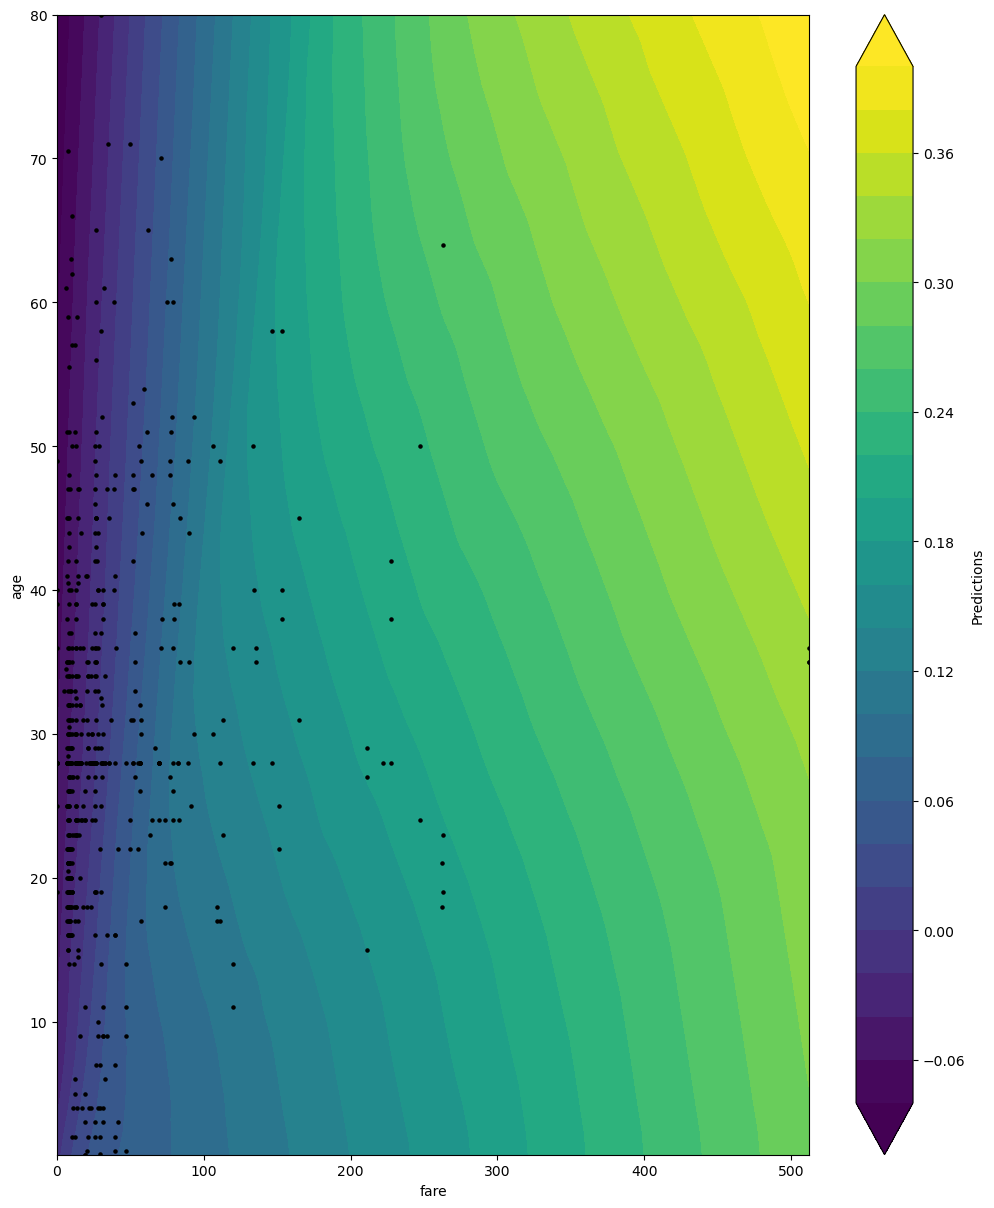

In [ ]:
model.plot()

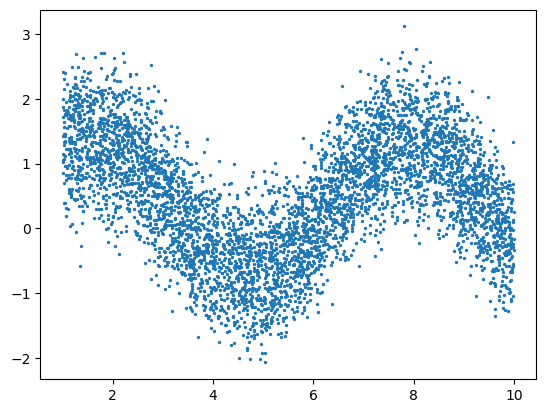

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(202)

# Number of data points
num_samples = 5000

# Define a list of possible categorical values
categories = ['A', 'B']

# Generate random categorical data as an array of strings
categorical1 = np.random.choice(categories, size=num_samples)

categories = ['Yes', 'No', 'Maybe']
categorical2 = np.random.choice(categories, size=num_samples)

# Generate the input variable X as a random draw from a linspace
X1 = np.random.uniform(1, 10, size=num_samples)
X2 = np.random.uniform(2, 4, size=num_samples)

# Generate continuous variables as a function of X with noise dependent on X
def func1(x):
    return 5*np.sin(x) / 5 

def func2(x):
    return -(2*(x-3))**2 / 5


# Create mappings for categorical values
category_map1 = {'A': 0.2, 'B': -0.1}
category_map2 = {'Yes': 0.0, 'No': -0.5, 'Maybe': 0.5}

# Calculate y by combining continuous and categorical functions
#
y = func1(X1) - func2(X2)  + np.vectorize(category_map1.get)(categorical1) + np.vectorize(category_map2.get)(categorical2) + np.random.normal(0, 0.3, size=num_samples) 


data = pd.DataFrame({"Target": y, 'Category1': categorical1, 'Category2': categorical2, 'Continuous1':X1, 'Continuous2':X2})


plt.scatter(X1, y, s=2)


In [138]:
categories1 = ["Unknown", "A", "B"]

categories2 = ["Unknown", "Yes", "No", "Maybe"]

In [139]:
from tqdm import tqdm
from xDL.utils.data_utils import *


A = []
B = []
Yes = []
No = []
Maybe = []

preds_cont1 = []
preds_cont2 = []

for i in tqdm(range(1)):
    model = NATT(
        "Target ~  -1 + MLP(Continuous1) +  MLP(Continuous2) + Transformer(Category1):Transformer(Category2)", 
        data=data, 
        feature_dropout=0.0001,
        out_activation="linear",
        ff_dropout=0.1, 
        dropout=0.1,
        attn_dropout=0.1,
        batch_size=2048
        )


    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(), "importances": None, "att_weights": None},
        metrics= {"output": ["mse", "mae"], "importances": None, "att_weights": None},)

    history = model.fit(
        model.training_dataset, 
        epochs=100, 
        validation_data=model.validation_dataset,
        verbose=0,
    )


    

    for cat1 in categories1:
        for cat2 in categories2:
            dataset = model.data.copy()
            dataset["Category1"] = np.repeat(cat1, len(dataset))
            dataset["Category2"] = np.repeat(cat2, len(dataset))

            dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
            dataset["Continuous2"] = np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), len(dataset))

            dataset = df_to_dataset(
                        dataset,
                        model.data,
                        model.input_dict,
                        model.y,
                        batch_size=1024,
                        shuffle=False,
                        feature_information=model.feature_information,
                        task=model.binning_task,
            )

            x, expl = model.encoder.predict(dataset, verbose=0)
            x = model.ln(x[:, 0, :])
            x = model.transformer_mlp(x)
            x = model.output_layer(x)

            if cat1 == "Unknown" and cat2 == "Unknown":
                offset = x.numpy().mean()

            elif cat1 == "A" and cat2=="Unknown":
                A.append(x.numpy().mean()-offset)
            
            elif cat1 == "B" and cat2=="Unknown":
                B.append(x.numpy().mean()-offset)

            elif cat1 == "Unknown" and cat2=="Yes":
                Yes.append(x.numpy().mean()-offset)

            elif cat1 == "Unknown" and cat2=="No":
                No.append(x.numpy().mean()-offset)

            elif cat1 == "Unknown" and cat2=="Maybe":
                Maybe.append(x.numpy().mean()-offset)

    preds_cont1.append(model.feature_nets[0].predict(dataset, verbose=0))
    preds_cont2.append(model.feature_nets[1].predict(dataset, verbose=0))


100%|██████████| 1/1 [04:01<00:00, 241.54s/it]


In [125]:
category_map1 = {'A': 0.2, 'B': -0.1}
category_map2 = {'Yes': 0.5, 'No': -0.5, 'Maybe': 1.0}

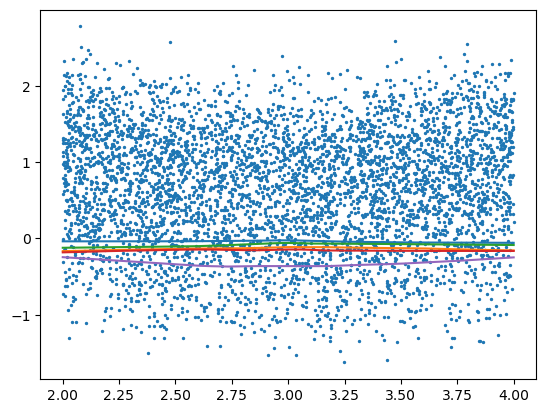

In [127]:
plt.scatter(X2, y, s=2)
for idx in range(5):
    plt.plot(np.linspace(data["Continuous2"].min(), data["Continuous2"].max(), 5000), preds_cont2[idx])

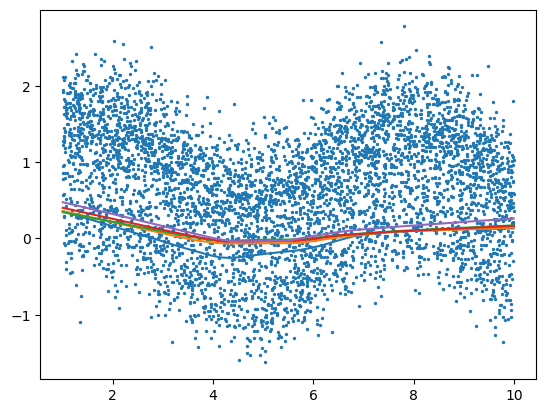

In [128]:
plt.scatter(X1, y, s=2)
for idx in range(5):
    plt.plot(np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), 5000), preds_cont1[idx])

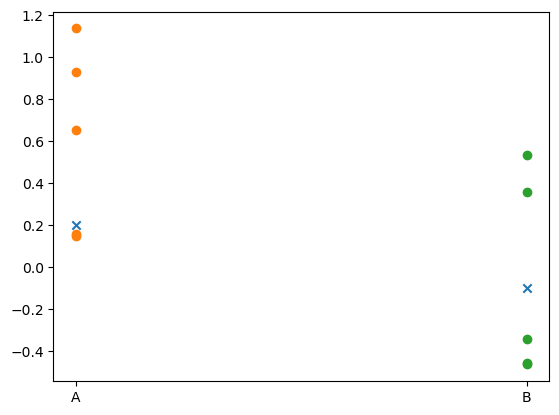

In [131]:
plt.scatter(["A", "B"], [0.2, -0.1], marker="x")
plt.scatter(np.repeat("A", 5), A)
plt.scatter(np.repeat("B", 5), B)

In [ ]:
category_map1 = {'A': 0.2, 'B': -0.1}
category_map2 = {'Yes': 0.5, 'No': -0.5, 'Maybe': 1.0}

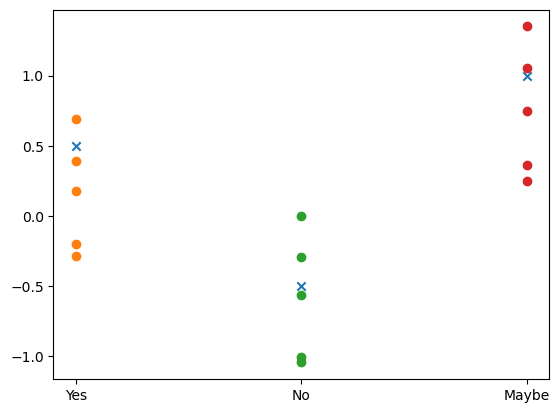

In [132]:
plt.scatter(["Yes", "No", "Maybe"], [0.5, -0.5, 1.0], marker="x")
plt.scatter(np.repeat("Yes", 5), Yes)
plt.scatter(np.repeat("No", 5), No)
plt.scatter(np.repeat("Maybe", 5), Maybe)

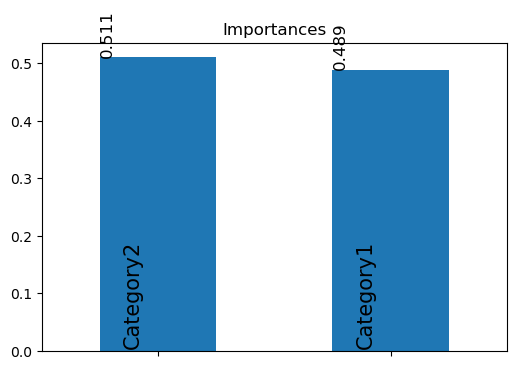

In [140]:
model.plot_importances()

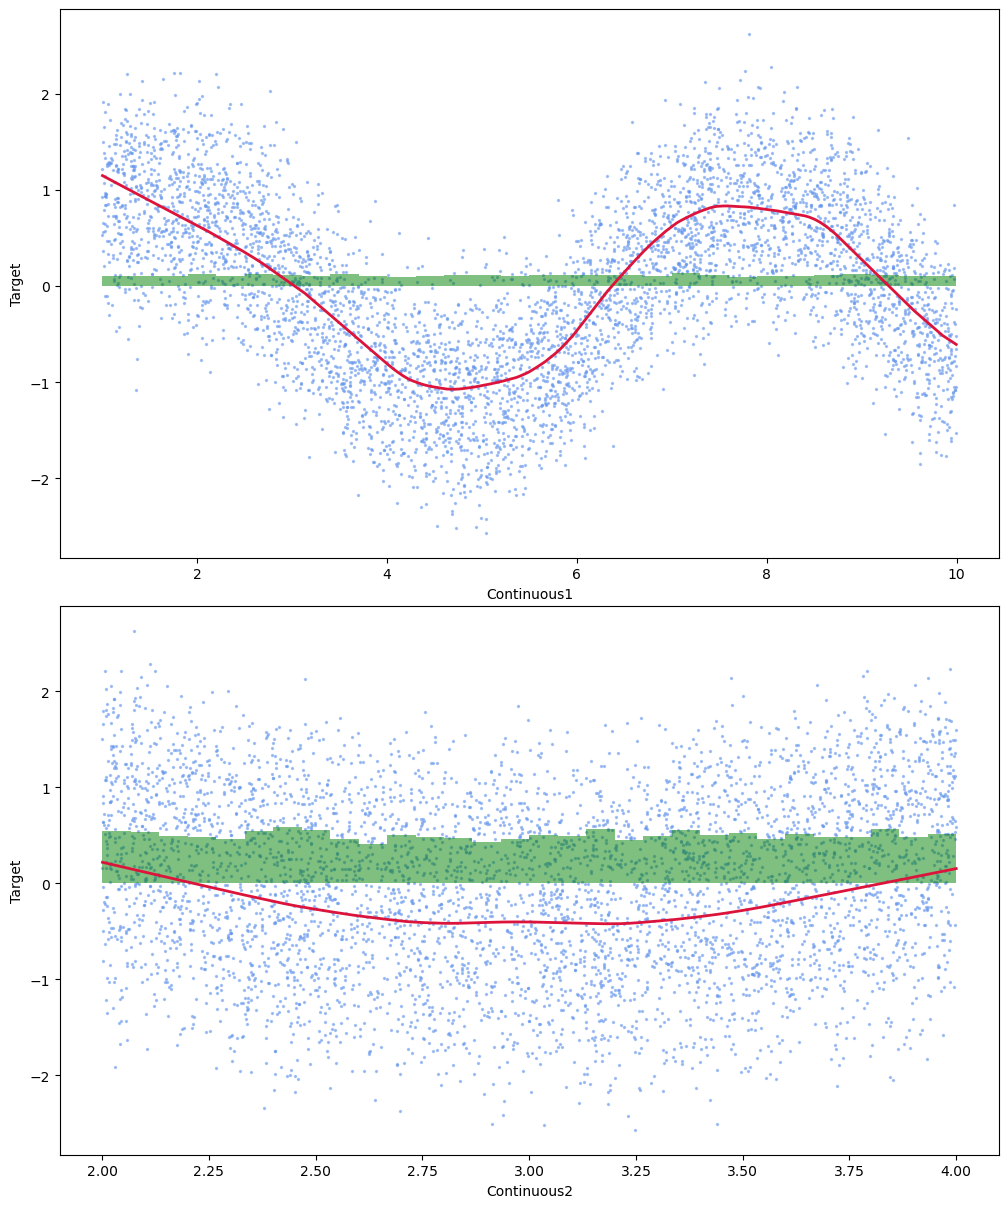

In [141]:
model.plot()

<Figure size 1200x400 with 0 Axes>

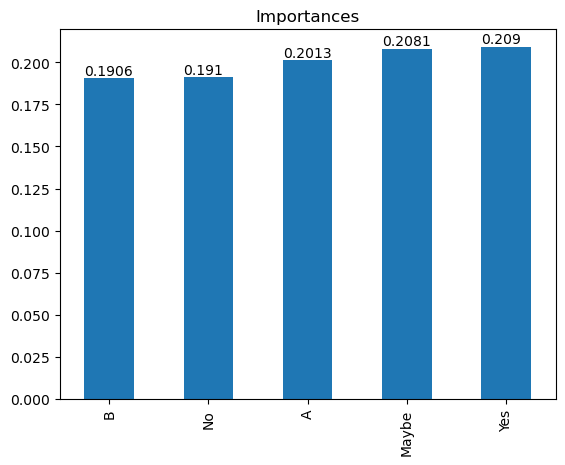

In [136]:
model.plot_categorical_importances()

In [116]:
data["cat1_values"] = np.vectorize(category_map1.get)(categorical1)
data["cat2_values"] = np.vectorize(category_map2.get)(categorical2)

In [117]:
data.head()

,Target,Category1,Category2,Continuous1,Continuous2,cat1_values,cat2_values
0,0.512775,B,Yes,8.940521,3.142173,-0.1,0.5
1,1.195631,B,Maybe,3.190082,3.510481,-0.1,1.0
2,1.321786,A,Yes,7.651040,2.193779,0.1,0.5
3,1.225735,A,Yes,3.643964,3.943233,0.1,0.5
4,1.552954,A,Yes,7.337154,2.398134,0.1,0.5


In [120]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(), "importances": None, "att_weights": None},
    metrics= {"output": ["mse", "mae"], "importances": None, "att_weights": None},)

history = model.fit(
    model.training_dataset, 
    epochs=50, 
    validation_data=model.validation_dataset,
    verbose=1,
)

AttributeError: 'XGBRegressor' object has no attribute 'compile'

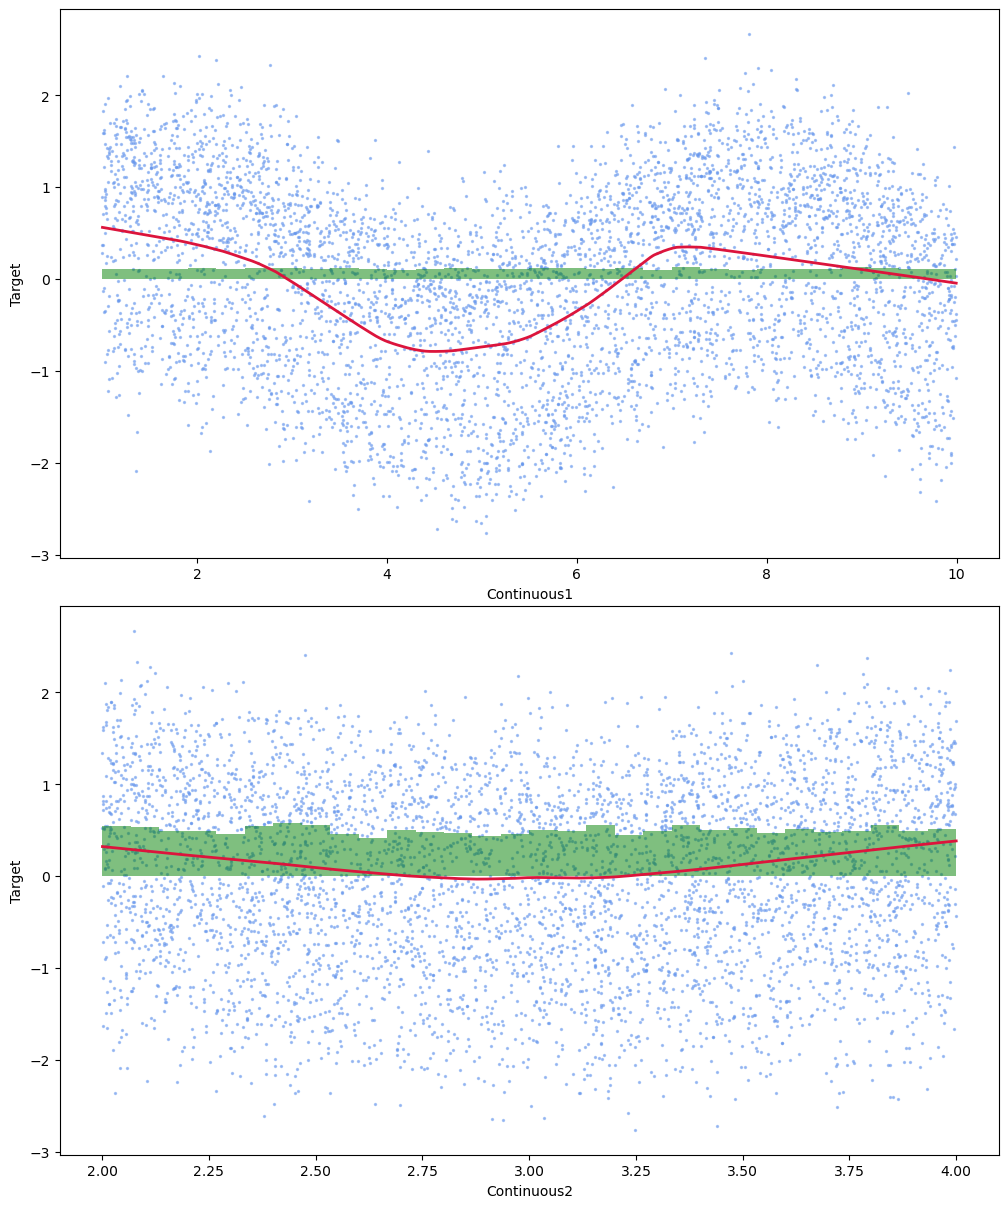

In [ ]:
model.plot()

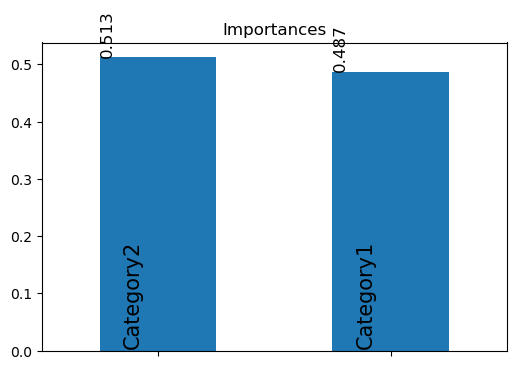

In [ ]:
model.plot_importances()

<Figure size 1200x400 with 0 Axes>

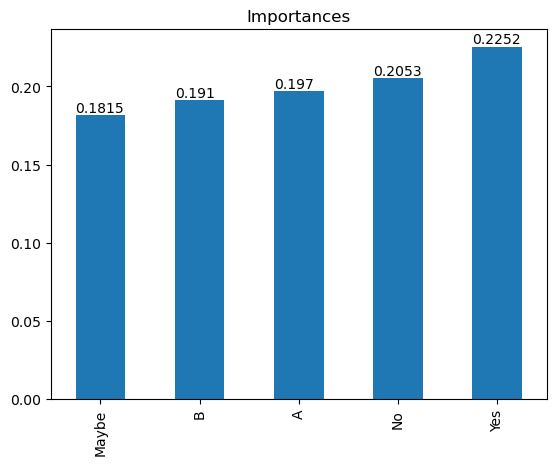

In [ ]:
model.plot_categorical_importances()

In [ ]:
from xDL.utils.data_utils import *

for cat1 in categories1:
    for cat2 in categories2:
        dataset = model.data.copy()
        dataset["Category1"] = np.repeat(cat1, len(dataset))
        dataset["Category2"] = np.repeat(cat2, len(dataset))

        dataset["Continuous1"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))
        dataset["Continuous2"] = np.linspace(data["Continuous1"].min(), data["Continuous1"].max(), len(dataset))

        dataset = df_to_dataset(
                    dataset,
                    model.data,
                    model.input_dict,
                    model.y,
                    batch_size=1024,
                    shuffle=False,
                    feature_information=model.feature_information,
                    task=model.binning_task,
        )

        x, expl = model.encoder.predict(dataset)
        x = model.ln(x[:, 0, :])
        x = model.transformer_mlp(x)
        x = model.output_layer(x)

        if cat1 == "Unknown" and cat2 == "Unknown":
            offset = x.numpy().mean()

        print(cat1, cat2, x.numpy().mean() - offset)

5/5 [==============================] - 0s 77ms/step
Unknown Unknown 0.0
5/5 [==============================] - 0s 71ms/step
Unknown Yes 0.42233303
5/5 [==============================] - 0s 72ms/step
Unknown No -0.9178872
5/5 [==============================] - 0s 72ms/step
Unknown Maybe 1.0705498
5/5 [==============================] - 0s 72ms/step
A Unknown 0.56502825
5/5 [==============================] - 0s 72ms/step
A Yes 0.53231615
5/5 [==============================] - 0s 71ms/step
A No -0.69423604
5/5 [==============================] - 0s 90ms/step
A Maybe 1.078909
5/5 [==============================] - 0s 71ms/step
B Unknown 0.06617364
5/5 [==============================] - 0s 72ms/step
B Yes 0.34125453
5/5 [==============================] - 0s 71ms/step
B No -0.93533075
5/5 [==============================] - 0s 79ms/step
B Maybe 0.9103663


In [ ]:
category_map1 = {'A': 0.1, 'B': -0.1}
category_map2 = {'Yes': 0.5, 'No': -0.5, 'Maybe': 1.0}

In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor(enable_categorical=True)
model.fit(data[["Continuous1", "Continuous2", "cat1_values", "cat2_values"]], data["Target"])
importances = pd.DataFrame(data={
    'Attribute': ["Continuous1", "Continuous2", "cat1_values", "cat2_values"],
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()